# Lesson 2 : LangGraph Components


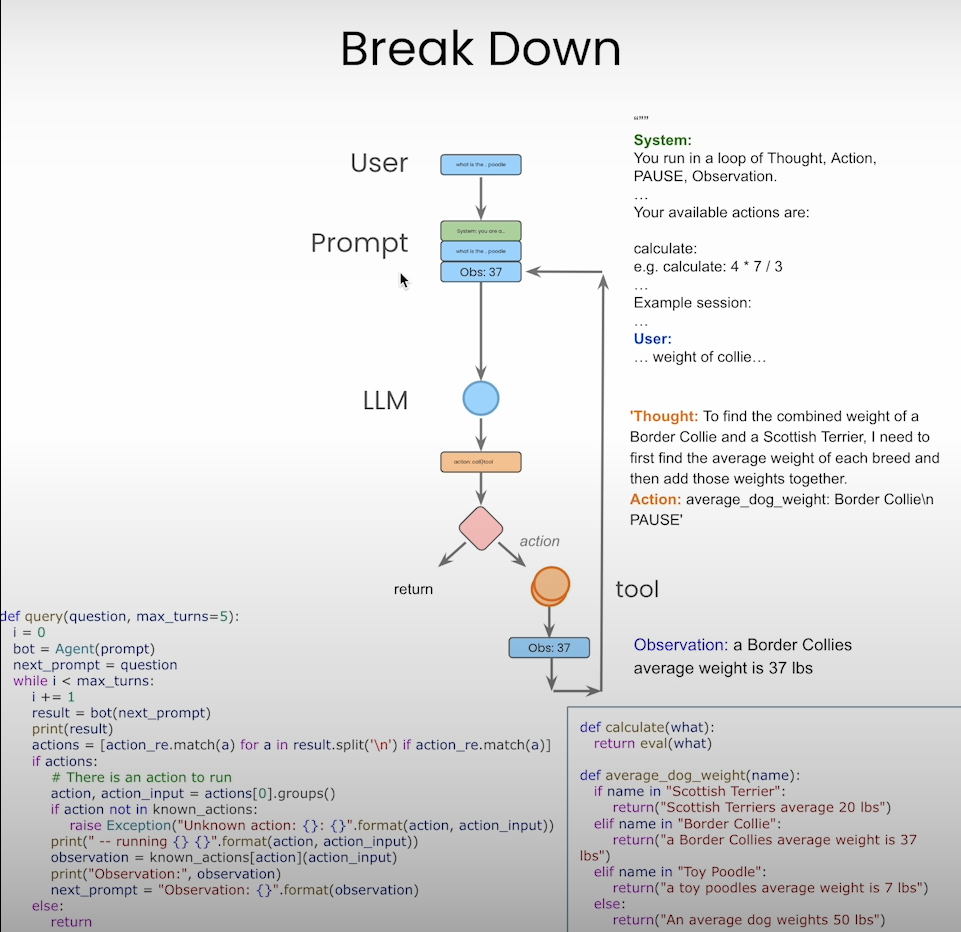


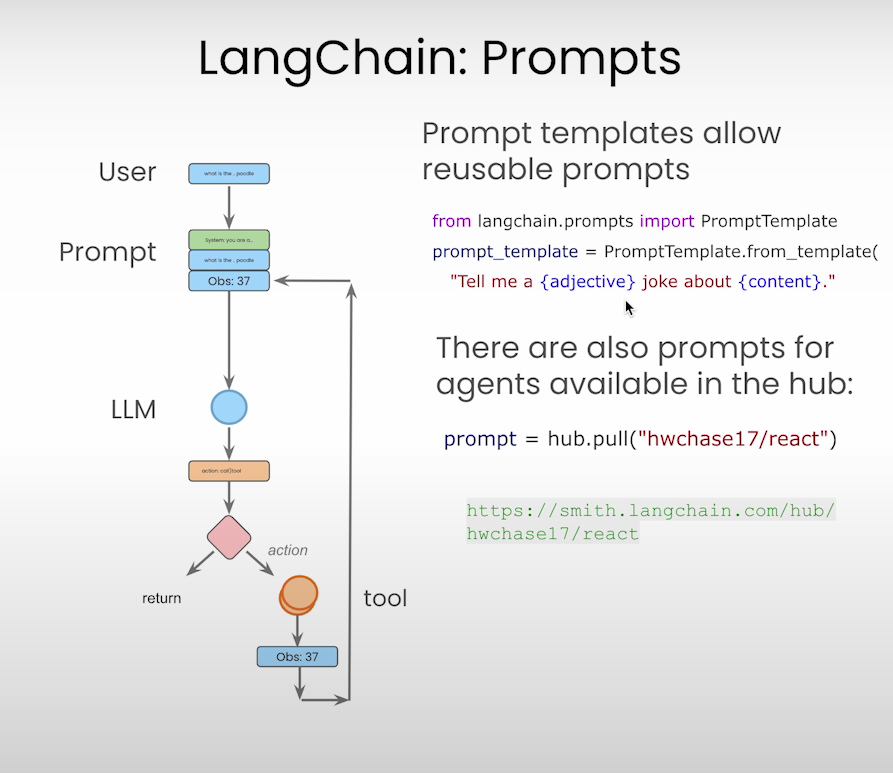


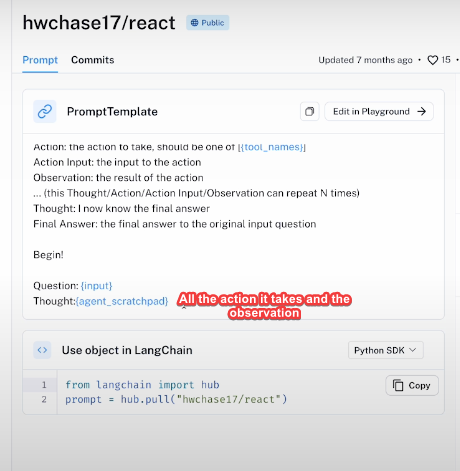


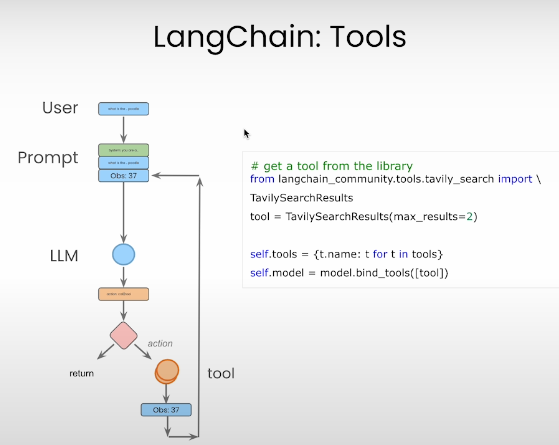


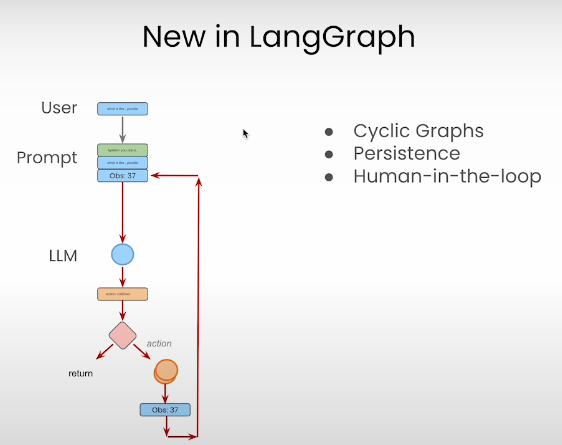


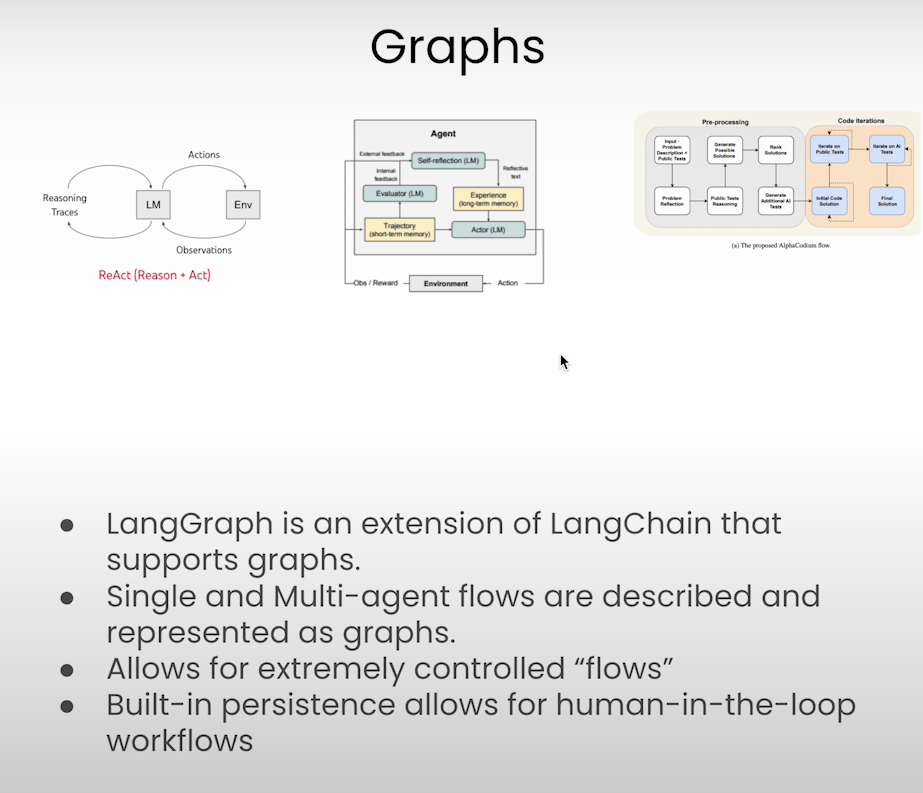


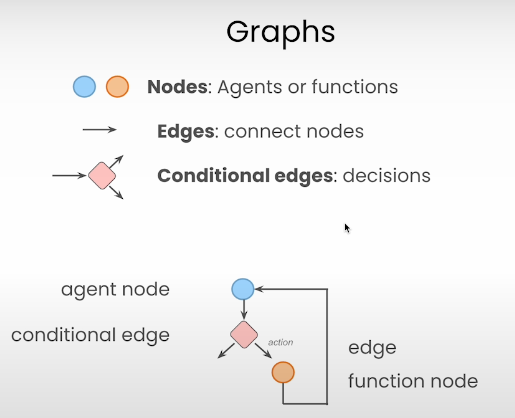


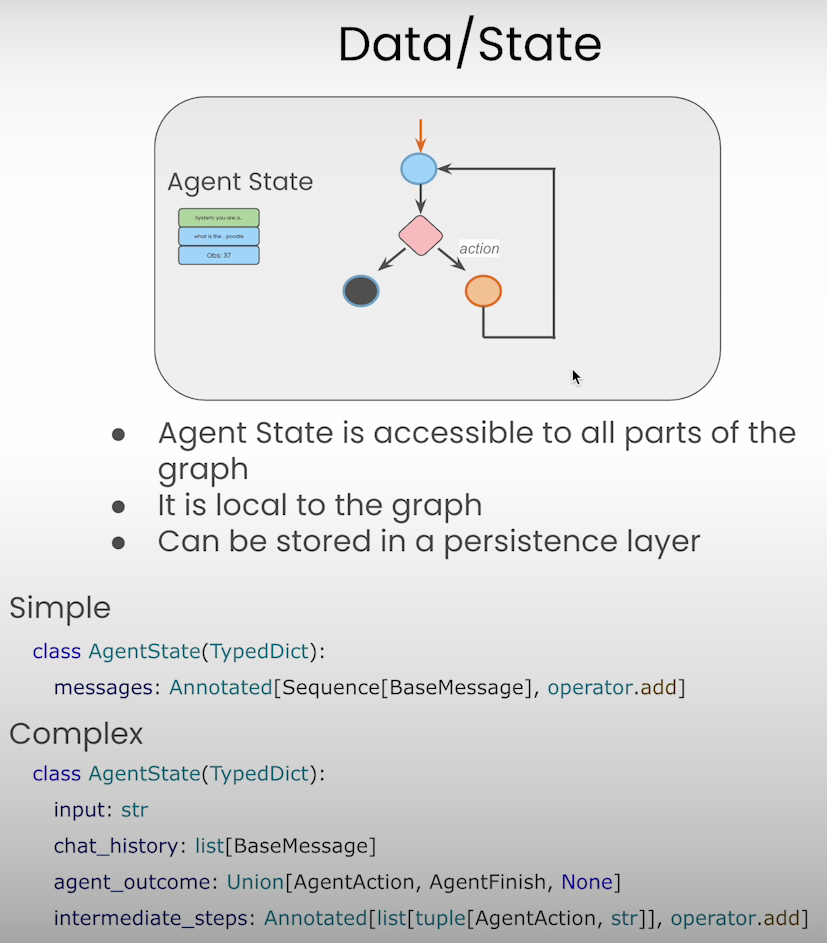


- Annotated + operator.add in `messages` and `intermediate_steps` means when adding new messages/Agent Action, it does't overwrite the old messages
- `input`, `chat_history`, `agent_outcome` are not Annotated, so when a new update is pushed to that variable, it will overwrite the old value


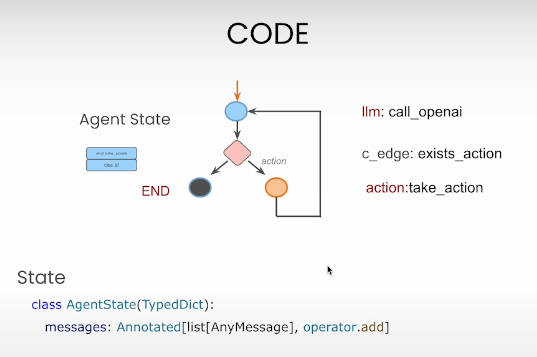


In [1]:
from dotenv import load_dotenv
_ = load_dotenv()

In [2]:
from langgraph.graph import StateGraph, END
from typing import TypedDict, Annotated
import operator
from langchain_core.messages import AnyMessage, SystemMessage, HumanMessage, ToolMessage
from langchain_openai import ChatOpenAI
from langchain_community.tools.tavily_search import TavilySearchResults

In [3]:
tool = TavilySearchResults(max_results=4)  # increased number of results
print(type(tool))
print(tool.name)

<class 'langchain_community.tools.tavily_search.tool.TavilySearchResults'>
tavily_search_results_json


> If you are not familiar with python typing annotation, you can refer to the [python documents](https://docs.python.org/3/library/typing.html). or [gpt-note](Lesson_2_Python_Typing_Annotation.pdf)


In [4]:
class AgentState(TypedDict):
    messages: Annotated[list[AnyMessage], operator.add]

> Note: in `take_action` below, some logic was added to cover the case that the LLM returned a non-existent tool name. Even with function calling, LLMs can still occasionally hallucinate. Note that all that is done is instructing the LLM to try again! An advantage of an agentic organization.


In [5]:
class Agent:

    def __init__(self, model, tools, system=""):
        self.system = system
        graph = StateGraph(AgentState)
        graph.add_node("llm", self.call_openai)
        graph.add_node("action", self.take_action)
        graph.add_conditional_edges(
            "llm",
            self.exists_action,
            {True: "action", False: END}
        )
        graph.add_edge("action", "llm")
        graph.set_entry_point("llm")
        self.graph = graph.compile()
        self.tools = {t.name: t for t in tools}
        self.model = model.bind_tools(tools)

    def exists_action(self, state: AgentState):
        result = state['messages'][-1]
        return len(result.tool_calls) > 0

    def call_openai(self, state: AgentState):
        messages = state['messages']
        if self.system:
            messages = [SystemMessage(content=self.system)] + messages
        message = self.model.invoke(messages)
        # Since we annotated as operation.add, this will not overwrite the messages state, instread it will append on it
        return {'messages': [message]}

    def take_action(self, state: AgentState):
        tool_calls = state['messages'][-1].tool_calls
        results = []
        for t in tool_calls:
            print(f"Calling: {t}")
            if not t['name'] in self.tools:      # check for bad tool name from LLM
                print("\n ....bad tool name....")
                result = "bad tool name, retry"  # instruct LLM to retry if bad
            else:
                result = self.tools[t['name']].invoke(t['args'])
            results.append(ToolMessage(
                tool_call_id=t['id'], name=t['name'], content=str(result)))
        print("Back to the model!")
        return {'messages': results}

In [6]:
prompt = """You are a smart research assistant. Use the search engine to look up information. \
You are allowed to make multiple calls (either together or in sequence). \
Only look up information when you are sure of what you want. \
If you need to look up some information before asking a follow up question, you are allowed to do that!
"""

model = ChatOpenAI(model="gpt-3.5-turbo")  # reduce inference cost
abot = Agent(model, [tool], system=prompt)

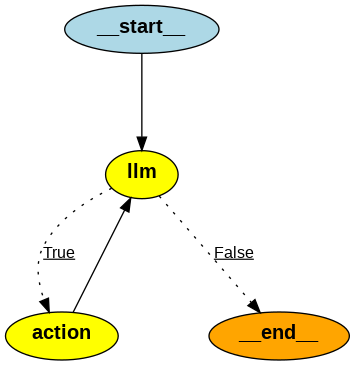

In [8]:
from IPython.display import Image

Image(abot.graph.get_graph().draw_png())

In [9]:
messages = [HumanMessage(content="What is the weather in sf?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hAwTIw4JwHvGbbrIa8zTO4ek', 'type': 'tool_call'}
Back to the model!


In [10]:
result

{'messages': [HumanMessage(content='What is the weather in sf?'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_hAwTIw4JwHvGbbrIa8zTO4ek', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 153, 'total_tokens': 174}, 'model_name': 'gpt-3.5-turbo-0125', 'system_fingerprint': None, 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-17281947-70a3-4a37-991a-b59b6947544b-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_hAwTIw4JwHvGbbrIa8zTO4ek', 'type': 'tool_call'}], usage_metadata={'input_tokens': 153, 'output_tokens': 21, 'total_tokens': 174}),
  ToolMessage(content='[{\'url\': \'https://www.weatherapi.com/\', \'content\': "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'l

In [11]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 64.0°F (17.8°C). The wind speed is 5.6 mph (9.0 kph) coming from the west-northwest direction. The humidity is at 78%, and the visibility is 9.0 miles.'

### Parallel tools/functions callings


In [12]:
messages = [HumanMessage(content="What is the weather in SF and LA?")]
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_aC1zNFBzR53nn4HdCGC4Kry3', 'type': 'tool_call'}
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'weather in Los Angeles'}, 'id': 'call_TaEZfk2Z85YSoX8tHpcFj9fJ', 'type': 'tool_call'}
Back to the model!


In [13]:
result['messages'][-1].content

'The current weather in San Francisco is partly cloudy with a temperature of 64.0°F (17.8°C). The wind is blowing at 5.6 mph from the west-northwest direction. The humidity is at 78%, and the visibility is 9.0 miles.\n\nIn Los Angeles, it is misty with a temperature of 70.0°F (21.1°C). The wind is blowing at 3.8 mph from the west-southwest direction. The humidity is at 76%, and the visibility is 4.0 miles.'

### Sequential tools/functions callings (Need response from previous tool to call the next tool)


In [14]:
# Note, the query was modified to produce more consistent results.
# Results may vary per run and over time as search information and models change.

query = "Who won the super bowl in 2024? In what state is the winning team headquarters located? \
What is the GDP of that state? Answer each question."
messages = [HumanMessage(content=query)]

model = ChatOpenAI(model="gpt-4o")  # requires more advanced model
abot = Agent(model, [tool], system=prompt)
result = abot.graph.invoke({"messages": messages})

Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Who won the Super Bowl in 2024?'}, 'id': 'call_dRPo9GAb8lFAuvzCib5UCqLZ', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'Kansas City Chiefs headquarters location'}, 'id': 'call_FyhHkxuKkfOmOeLJlvyZDJUB', 'type': 'tool_call'}
Back to the model!
Calling: {'name': 'tavily_search_results_json', 'args': {'query': 'current GDP of Missouri'}, 'id': 'call_COJRy15QQhVNa1XcOOomn55W', 'type': 'tool_call'}
Back to the model!


In [15]:
print(result['messages'][-1].content)

1. **Who won the Super Bowl in 2024?**
   - The Kansas City Chiefs won the Super Bowl in 2024, defeating the San Francisco 49ers 25-22 in overtime.

2. **In what state is the winning team's headquarters located?**
   - The Kansas City Chiefs' headquarters is located in Missouri.

3. **What is the GDP of that state?**
   - As of 2023, the GDP of Missouri is approximately $344.12 billion USD.
